In [1]:
#========================================================================
# Copyright 2019 Science Technology Facilities Council
# Copyright 2019 University of Manchester
#
# This work is part of the Core Imaging Library developed by Science Technology	
# Facilities Council and University of Manchester
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0.txt
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# 
#=========================================================================

# Reconstruction intro
## FBP, CGLS

**The goal** of this notebook is to get familiar with main Framework concepts through basic filtered-back projection (FBP) and Conjugate Gradient Least Squares (CGLS) reconstructions.

**Learning objectives**
In the end of this session, participants will be able to:
- translate output of a CT instrument into Framework objects
- set-up basic FBP reconstruction
- formulate CT reconstruction as an optimisation problem and solve it iteratively
- visualise final and intermediate reconstruction results

In [2]:
# some imports 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
# define some utilities

# imports
from ccpi.framework import ImageData, ImageGeometry
from ccpi.framework import AcquisitionData, AcquisitionGeometry
from ccpi.astra.operators import AstraProjectorSimple 

import numpy as np
import matplotlib.pyplot as plt

# simulate 'ideal', i.e. noise-free, sino
def get_ideal_sino(data, N, n_angles):
    
    # get ImageGeometry
    ig = data.geometry

    # Create AcquisitionGeometry
    angles = np.linspace(0, np.pi, n_angles, dtype=np.float32)

    ag = AcquisitionGeometry(geom_type = "parallel",
                             dimension = "2D", 
                             angles = angles,
                             pixel_num_h = N)

    dev = "cpu"

    Aop = AstraProjectorSimple(ig, ag, dev)    
    sino = Aop.direct(data)
    return sino.as_array()


# simulate noisy projetion, flat and adrk field images
def get_real_sino(data, N, n_angles, n_bit):
    
    # detector bit depth
    n_levels = 2 ** n_bit - 1
    I_0 = 0.9 * n_levels
    
    # center of rotation offset
    cor_offset = 0
    
    # shift senter of rotation
    sino = np.roll(get_ideal_sino(data, N, n_angles), cor_offset, axis = 1)
    
    # generate flat field image (i.e. imitate non-uniform pixel response)
    flat = np.uint32(np.tile(np.round(I_0 - I_0 * 0.1 * np.random.rand(1, N)), (n_angles, 1)))
    
    # generate dark field image (i.e. imitate dark current)
    dark = np.uint32(np.tile(np.round(I_0 * 0.05 * np.random.rand(1, N)), (n_angles, 1)))
    
    # add noise to flat field image
    flat_noisy = np.random.poisson(flat)
    
    # add dark current
    flat_noisy += dark
    
    # based on ideal sinogram, generate projection image and add noise 
    proj = np.uint32(flat * np.exp(-sino))
    proj_noisy = np.random.poisson(proj)
    
    # add dark current
    proj_noisy += dark
    
    proj_noisy = np.float32(np.clip(proj_noisy, 0, n_levels))
    flat_noisy = np.float32(np.clip(flat_noisy, 0, n_levels))
    dark = np.float32(np.clip(dark, 0, n_levels)) 
    
    return proj_noisy, flat_noisy, dark


def plotter2D(datacontainers, titles, fix_range=False, stretch_y=False):
    '''plotter2D(datacontainers, titles, fix_range=False, stretch_y=False)
    
    plots 1 or more 2D plots in an (n x 2) matix
    multiple datasets can be passed as a list
    
    Can take ImageData, AquistionData or numpy.ndarray as input
    '''
    if(isinstance(datacontainers, list)) is False:
        datacontainers = [datacontainers]

    if(isinstance(titles, list)) is False:
        titles = [titles]
    
    nplots = len(datacontainers)
    rows = int(round((nplots+0.5)/2.0))

    fig, (ax) = plt.subplots(rows, 2,figsize=(15,15))

    axes = ax.flatten() 

    range_min = float("inf")
    range_max = 0
    
    if fix_range == True:
        for i in range(nplots):
            if type(datacontainers[i]) is np.ndarray:
                dc = datacontainers[i]
            else:
                dc = datacontainers[i].as_array()
                
            range_min = min(range_min, np.amin(dc))
            range_max = max(range_max, np.amax(dc))
        
    for i in range(rows*2):
        axes[i].set_visible(False)

    for i in range(nplots):
        axes[i].set_visible(True)
        axes[i].set_title(titles[i])
       
        if type(datacontainers[i]) is np.ndarray:
            dc = datacontainers[i]
        else:
            dc = datacontainers[i].as_array()    
        
        sp = axes[i].imshow(dc)
        
        im_ratio = dc.shape[0]/dc.shape[1]
        
        if stretch_y == True:   
            axes[i].set_aspect(1/im_ratio)
            im_ratio = 1
        
        plt.colorbar(sp, ax = axes[i],fraction = 0.0467 * im_ratio, pad = 0.02)
        
        if fix_range == True:
            sp.set_clim(range_min,range_max)

## CT data acquisition

In conventional CT systems, an object is placed between a source emitting X-rays and a detector array measuring the  X-ray transmission images of the incident X-rays. Typically, either the object is placed on a rotating sample stage and rotates with respect to the source-detector assembly, or the source-detector gantry rotates with respect to the stationary object.

In the Framework, we implemented `AcquisitionGeometry` class to hold acquisition parameters and `ImageGeometry` to hold geometry of a reconstructed volume. Corresponding data arrays are wrapped as `AcquisitionData` and `ImageData` classes, respectively. In this notebook we will work with parallel geometry. More complex geometries will be discussed in the following notebooks. Geometrical parameters for parallel geometry are depicted below:

<img src="figures/parallel_geometry.png" width=600 height=600 align="left">

In the Framework, we define parallel `AcquisitionGeometry` as follows.

In [4]:
# imports
from ccpi.framework import AcquisitionGeometry
import numpy as np

# acquisition angles
n_angles = 360
angles = np.linspace(0, np.pi, n_angles, dtype = np.float32)

# number of pixels in detector row
N = 512

# pixel size
pixel_size_h = 1

# # create AcquisitionGeometry
ag = AcquisitionGeometry(geom_type = "parallel",
                         dimension = "2D",
                         angles = angles,
                         pixel_num_h = N,
                         pixel_size_h = pixel_size_h)

print("Acquisition geometry:\n{}".format(ag))

Acquisition geometry:
Number of dimensions: 2D
angles: [0.         0.00875095 0.01750191 0.02625286 0.03500382 0.04375477
 0.05250573 0.06125668 0.07000764 0.07875859 0.08750954 0.0962605
 0.10501146 0.11376241 0.12251336 0.13126431 0.14001527 0.14876622
 0.15751718 0.16626814 0.17501909 0.18377005 0.19252099 0.20127195
 0.21002291 0.21877386 0.22752482 0.23627578 0.24502672 0.25377768
 0.26252863 0.2712796  0.28003055 0.2887815  0.29753244 0.3062834
 0.31503436 0.3237853  0.33253628 0.34128723 0.35003817 0.35878915
 0.3675401  0.37629104 0.38504198 0.39379296 0.4025439  0.41129485
 0.42004582 0.42879677 0.4375477  0.4462987  0.45504963 0.46380058
 0.47255155 0.4813025  0.49005345 0.4988044  0.50755537 0.51630634
 0.52505726 0.53380823 0.5425592  0.5513101  0.5600611  0.568812
 0.577563   0.58631396 0.5950649  0.60381585 0.6125668  0.62131774
 0.6300687  0.6388197  0.6475706  0.6563216  0.66507256 0.6738235
 0.68257445 0.6913254  0.70007634 0.7088273  0.7175783  0.7263292
 0.7350802  0

`AcquisitionGeometry` contains only metadata, the actual data is wrapped in `AcquisitionData` class.`AcquisiitonGeometry` class also holds information about arrangement of the actual acquisition data array. We use attribute `dimension_labels` to label axis. The expected dimension labels are shown below:

<img src="figures/parallel_data.png" width=300 height=300 align="left">

The default order of dimensions for `AcquisitionData` is `[angle, horizontal]`, meaning that the number of elements along 0 and 1 axes in the acquisition data array is expected to be `n_angles` and `N`, respectively.

In [5]:
print("Dimension labels:\n{}".format(ag.dimension_labels))

Dimension labels:
[u'angle', u'horizontal']


To have consistent `AcquisitionData` and `AcquisitionGeometry`, we recommend to allocate `AcquisitionData` using `allocate` method of `AcquisitionGeometry` class:

In [6]:
# imports
from ccpi.framework import AcquisitionData
import matplotlib.pyplot as plt
%matplotlib inline

# allocate AcquisitionData
ad = ag.allocate()

print("Dimensions and Labels = {}, {}".format(ad.shape, ad.dimension_labels))

Dimensions and Labels = (360, 512), {0: u'angle', 1: u'horizontal'}


The Framework provides a number of test images

- BOAT = 'boat.tiff'
- CAMERA = 'camera.png'
- PEPPERS = 'peppers.tiff'
- RESOLUTION_CHART = 'resolution_chart.tiff'
- SIMPLE_PHANTOM_2D = 'hotdog'
- SHAPES = 'shapes.png'
    
Here we load a 'hotdog' image (a simple CT phantom consisting of 2 materials) and generate a sinogram.

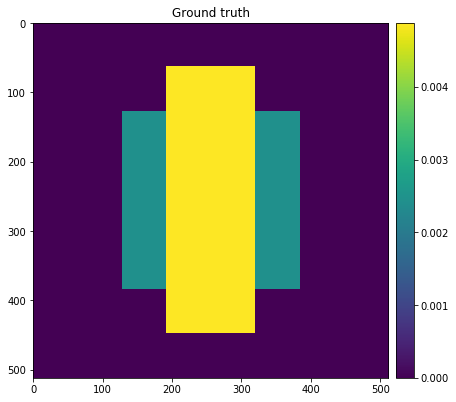

In [7]:
from ccpi.framework import TestData
import os, sys

# load test image
# initialise loader
loader = TestData(data_dir = os.path.join(sys.prefix, "share", "ccpi"))
# load data
data = loader.load(TestData.SIMPLE_PHANTOM_2D, size = (N, N))
# scale data
data *= 2.5 / N

plotter2D([data],
          ["Ground truth"])

Now, we can pass actual sinogram to `AcquisitionData`:

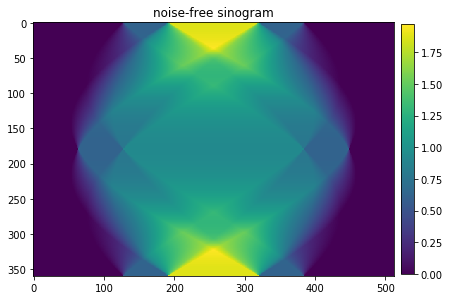

In [8]:
ad.fill(get_ideal_sino(data, N, n_angles))

plotter2D([ad],
          ["noise-free sinogram"])

## CT data preprocessing

As X-ray photons travel from an X-ray source to detector elements they interact with matter along their trajectories. In these interactions, photons are either absorbed or scattered, resulting in the attenuation of the incident X-ray. A quantitative description of the interaction of X-rays with matter is given by the Beer-Lambert law (or Beer’s law).
$$I^{l} = I^0 \mathrm{exp}\left( -\int_{l} f(g) \mathrm{d}l \right)$$
where $f(g)$ is the X-ray linear attenuation coefficient of the object at the position $g$ along a given linear X-ray trajectory $l$ from the source to the detector element. If $l$ is the entire trajectory from the source to the detector element, then $I^0$ corresponds to the X-ray intensity upon emission from the source and $I^{l}$ corresponds to the X-ray intensity upon incidence on the detector element. $I^{l}$ is typically called a transmission measurement, whereas a projection measurement is given by
$$G^{l} = -\log \left( \frac{I^{l}}{I^0} \right) = \int_{l} f(g) \mathrm{d}l$$

Ideally, $I^0$ is a single value, but real detector pixels do respond equally to photon flux. Secondly, pixels might have residual charge (so called dark current). Therefore, to convert $I^{l}$ to $G^{l}$, one needs to perform flat field correction. If $I^F$ is a flat field image (acquired with source on, without an object in the field of view) and $I^d$ is a dark field image (acquired with source off), then flat field correction is given by:
$$\frac{I-I^D}{I^F-I^D}$$

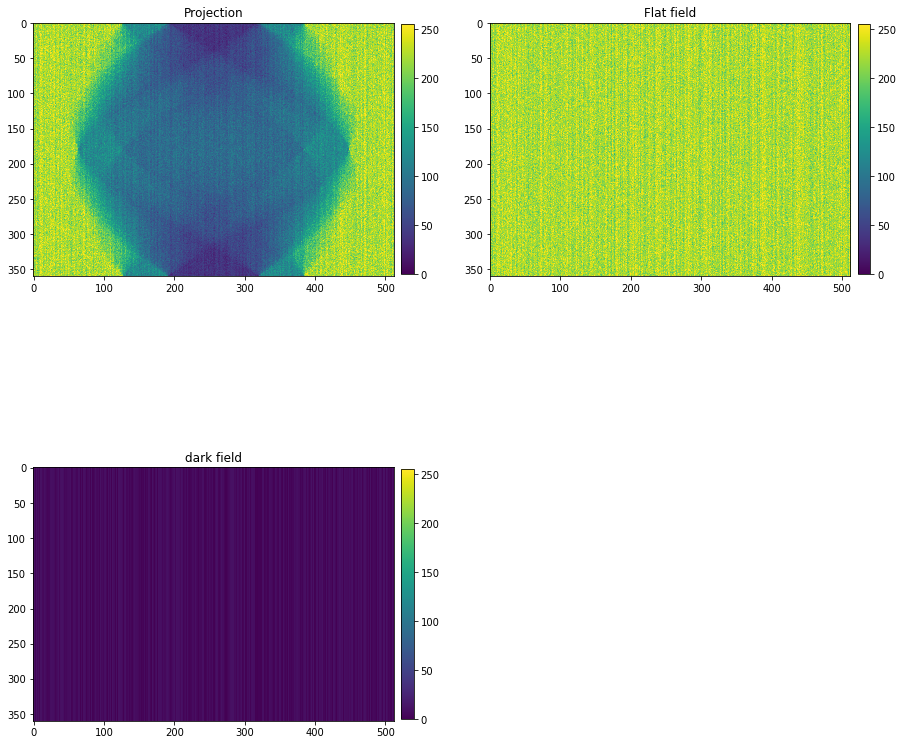

In [9]:
# simulated noisy sinogram, flat and dark field images
proj_tmp, flat_tmp, dark_tmp  = get_real_sino(data, N, n_angles, 8)

plotter2D([proj_tmp, flat_tmp, dark_tmp], 
          ["Projection", "Flat field", "dark field"], 
          fix_range = True, 
          stretch_y = False)

In [10]:
proj_noisy = ag.allocate()
proj_noisy.fill(proj_tmp)

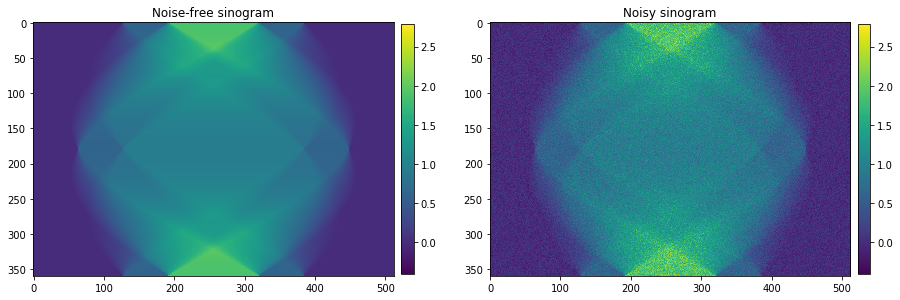

In [11]:
# wrap  flat and dark field images as AcquisitionData objects
flat = ag.allocate()
flat.fill(flat_tmp)
dark = ag.allocate()
dark.fill(dark_tmp)

# and perform flat field correction and take negative logarithm
ad_noisy = -1*(((proj_noisy - dark) / (flat - dark)).log())

plotter2D([ad, ad_noisy], 
          ["Noise-free sinogram", "Noisy sinogram"], 
          fix_range = True, 
          stretch_y = False)

As you see, we defined algebraic operations for `AcquisitionData` objects, i.e. you can manipulate them as `numpy` arrays.

## CT reconstruction
Tomographic reconstruction consists of resolving the three-dimensional photon attenuation map of a scanned object from the collection of projection measurement $G^{l}$. There are two major classes of reconstruction algorithms: *analytic* and *iterative*. 

### Analytic reconstruction
The most common analytic reconstruction algorithm is filtered back-projection (FBP). The FBP algorithm is derived from the Fourier Slice theorem which relates line integral measurements to two dimensional Fourier transform of an object’s slice. Although the Fourier Slice theorem provides straightforward solution for tomographic reconstruction, its practical implementation is challenging due to required interpolation from Polar to Cartesian coordinates in the Fourier space. In FBP-type reconstruction methods, projections are ﬁltered independently and then back-projected onto the plane of the tomographic slice. Filtration is used to compensate for nonuniform sampling of the Fourier space (higher frequencies have higher density of sampling points) by linear (Ramp) weighting of the frequency space.

To store reconstruction results, we implemented two classes: `ImageGeometry` and `ImageData`. Similar to `AcquisitionData` and `AcquisitionGeometry`, we first define 2D `ImageGeometry`.

In [12]:
# imports
from ccpi.astra.processors import FBP

# reconstruction settings
dev = "cpu" # can be "gpu"

# create ImageGeometry 
ig = ImageGeometry(voxel_num_x = ag.pixel_num_h,
                   voxel_size_x = ag.pixel_size_h,
                   voxel_num_y = ag.pixel_num_h,
                   voxel_size_y = ag.pixel_size_h)

FBP algorithm is implemented as a `processor` which takes as an input `AcquisitionData` along with `AcquisitionGeometry` and `ImageGeometry`, and returns reconstructed `ImageData`.

In [13]:
# reconstruct noise-free data
# configure FBP
fbp = FBP(volume_geometry = ig, 
          sinogram_geometry = ag,
          device = dev)
# pass actual AcquisitionData
fbp.set_input(ad)
# run FBP and get results
recon_fbp_ideal = fbp.process()

# reconstruct noisy data
fbp.set_input(ad_noisy)
recon_fbp_noisy = fbp.process()

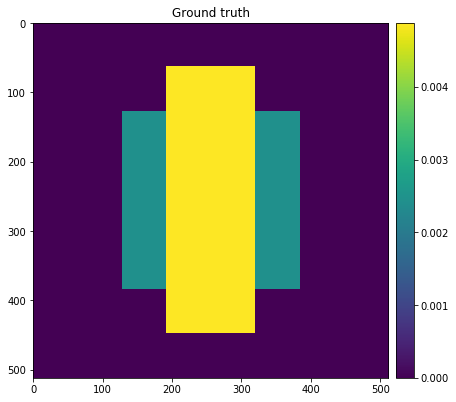

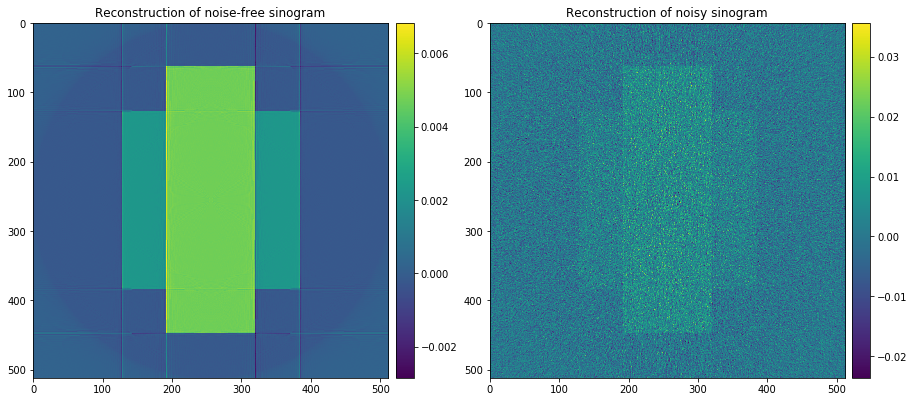

In [14]:
plotter2D([data], 
          ["Ground truth"])

plotter2D([recon_fbp_ideal, recon_fbp_noisy], 
          ["Reconstruction of noise-free sinogram", "Reconstruction of noisy sinogram"], 
          fix_range = False, 
          stretch_y = False)

`ImageData` and `AcquisitionData` inherit from the same `DataContainer` class, consequently they behave the same way. For instance, we can subtract ground truth from the reconstruction results to visualise residuals.

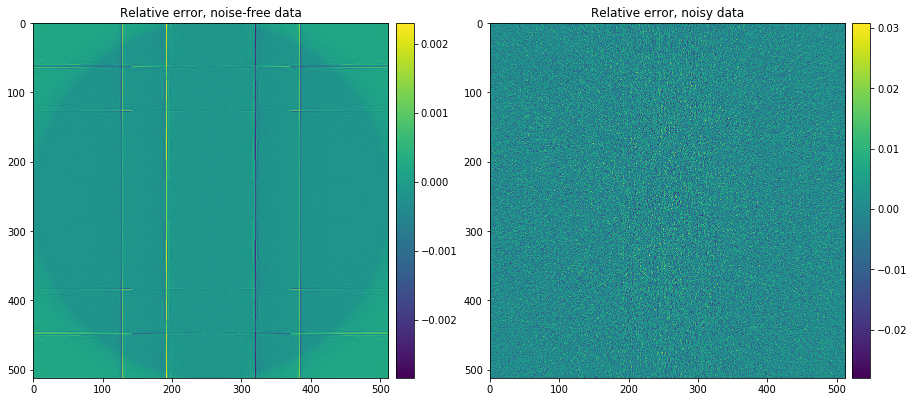

In [15]:
# show residuals
plotter2D([(recon_fbp_ideal - data), (recon_fbp_noisy - data)], 
          ["Relative error, noise-free data", "Relative error, noisy data"], 
          fix_range = False, 
          stretch_y = False)

<a id='exercise_1'></a>
**Exercise 1**: use the following mask to simulate missing angles acquisition and perform reconstruction again for both noise-free and noisy data.

New acquisition angles are now given by the following `mask`:
```
a = np.int32((np.arange(1,28) * np.arange(0,27)) / 4)
mask = np.concatenate([a, n_angles - 1 - a[::-1]])
```

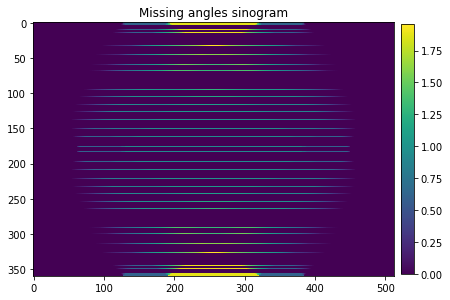

In [16]:
a = np.int32(np.round((np.arange(1,28) * np.arange(0,27)) / 4))
mask = np.concatenate([a, n_angles - 1 - a[::-1]])

# visualise new sinogram
sino_masked = np.zeros_like(ad.as_array())
sino_masked[mask, :] = ad.as_array()[mask, :]

plotter2D([sino_masked],
          ["Missing angles sinogram"])

*Hint*: you do not need to generate sinograms again, you can create new `AcquisitionGeometry` and `AcquisitionData` using `numpy` slicing, for instance:
```
ad_low = ag_low.allocate()
ad_low.fill(ad.as_array()[mask,:])
```

#### Iterative reconstruction
As you have seen in the exercise, FBP reconstruction fails to reconstruct the dataset with low number of projections. Alternatively, iterative reconstruction methods tend to have better perfomance for datasets with low number of projections and/ or missing angles.

Iterative methods use an initial estimate of volume voxel values which is then iteratively updated to best reproduce acquired radiographic data. Here we discuss formulation of iterative reconstruction for 2D parallel gemetry, extension to other geometies is straightforward. Iterative methods formulate the reconstruction methods as a system of linear equations,

$$Ax = b$$

- $x$ is the volume to be reconstructed. $x$ is typically represented as a column vector with $N \cdot N \times 1$ elements, where $N$ is the number of elements in a detector row.
- $b$ is measured data from $M$ measurements (projections), $b$ is a column vector with $N \cdot M \times 1$ elements
- $A$ is the projection operator with $N \cdot M \times N \cdot N$ elements. If $i, i = \{0, 1, \dots N \cdot M - 1 \}$ and $j, j = \{0, 1, \dots, N \cdot N - 1\}$, then $A_{i,j}$ is the length of intersection of the $i$.th ray with the $j$.th voxel.

For any real application, problem size is too large to be solved by direct inversion methods, i.e.

$$x = A^{-1}b$$

Secondly, the projection matrix $A$ is often under-determined (low number of projections or missing angles), i.e. 

$$M \ll N$$

Therefore we formulate reconstruction as an optimization problem and use iterative solvers to solve:

$$\underset{x}{\mathrm{argmin}}\begin{Vmatrix}A x - b\end{Vmatrix}^2_2$$

Since iterative methods involve forward- and back-projection steps, assumptions of data acquisition, data processing, system geometries, and noise characteristic can be incorporated into the reconstruction procedure. However, iterative methods are computationally demanding, you will notice that it takes longer to get reconstruction results with iterative methods.

From mathematical point of view, projection matrix $A$ is an operator which maps from the set $x$ (*domain*) to the set $b$ (*range*):
$$A: x \to b$$
In the framework, we implemented a generic `operator` class. The two most important methods of the `operator` are `direct` and `adjoint` methods that describe the result of applying the operator, and its adjoint respectively, onto a compatible `DataContainer` (`AcquisitionData` or `ImageData`) input. The output is another `DataContainer` object or subclass hereof. An important special case of the `operator` class, is the projection operator for CT, where `direct` and `adjoint` method correspond to forward- and back-projection respectively.

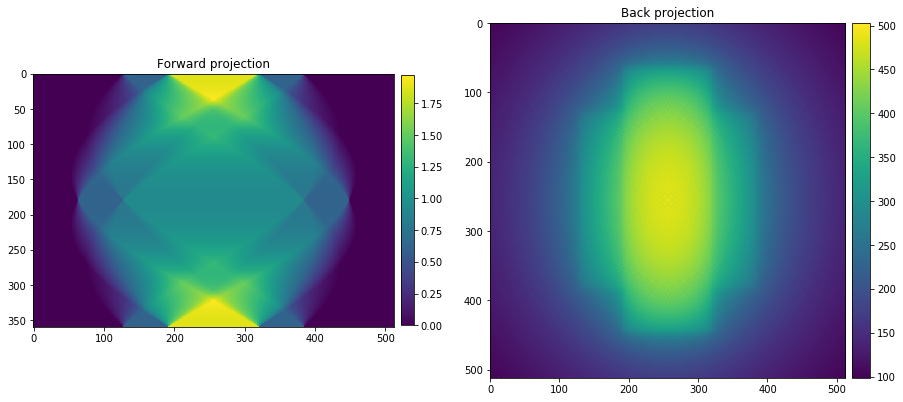

In [17]:
# imports
from ccpi.astra.operators import AstraProjectorSimple 

# define the projection operator A
device = "cpu" # or "gpu" if available
operator = AstraProjectorSimple(ig, ag, device)

# forward projection
forward_projection = operator.direct(data)

# back_projection
back_projection = operator.adjoint(forward_projection)

plotter2D([forward_projection, back_projection],
          ["Forward projection", "Back projection"],
          fix_range = False)

In [18]:
print("Range: {} \n".format(operator.range_geometry()))
print("Domain: {} \n".format(operator.domain_geometry()))

Range: Number of dimensions: 2D
angles: [0.         0.00875095 0.01750191 0.02625286 0.03500382 0.04375477
 0.05250573 0.06125668 0.07000764 0.07875859 0.08750954 0.0962605
 0.10501146 0.11376241 0.12251336 0.13126431 0.14001527 0.14876622
 0.15751718 0.16626814 0.17501909 0.18377005 0.19252099 0.20127195
 0.21002291 0.21877386 0.22752482 0.23627578 0.24502672 0.25377768
 0.26252863 0.2712796  0.28003055 0.2887815  0.29753244 0.3062834
 0.31503436 0.3237853  0.33253628 0.34128723 0.35003817 0.35878915
 0.3675401  0.37629104 0.38504198 0.39379296 0.4025439  0.41129485
 0.42004582 0.42879677 0.4375477  0.4462987  0.45504963 0.46380058
 0.47255155 0.4813025  0.49005345 0.4988044  0.50755537 0.51630634
 0.52505726 0.53380823 0.5425592  0.5513101  0.5600611  0.568812
 0.577563   0.58631396 0.5950649  0.60381585 0.6125668  0.62131774
 0.6300687  0.6388197  0.6475706  0.6563216  0.66507256 0.6738235
 0.68257445 0.6913254  0.70007634 0.7088273  0.7175783  0.7263292
 0.7350802  0.74383116 0.752

In [19]:
print("Operator norm: {}\n".format(operator.norm()))

Operator norm: 419.938258111



The Framework provides a number of generic optimisation algorithms implementations. All algorithms share the same interface and behaviour. Algorithms are iterable Python object which can be run in a for loop. Can be stopped and warm restarted.

The Conjugate Gradient Least Squares (CGLS) algorithm is commonly used for solving large systems of linear equations, due to its fast convergence. CGLS takes `operator`, measured data and initial value as an input.

In [20]:
# imports
from ccpi.optimisation.algorithms import CGLS

# initial estimate - zero array in this case 
x_init = ig.allocate(0)

# setup CGLS
cgls = CGLS(x_init = x_init, 
            operator = operator, 
            data = ad)
cgls.max_iteration = 10
cgls.update_objective_interval = 1

CGLS setting up
CGLS configured


In [21]:
# run N interations
cgls.run(10, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          1.26805e+05
        1         10         0.000          1.71970e+04
        2         10         1.398          9.81005e+02
        3         10         1.573          2.21807e+02
        4         10         1.455          5.76464e+01
        5         10         1.409          2.66631e+01
        6         10         1.340          1.72837e+01
        7         10         1.408          1.49318e+01
        8         10         1.395          8.00585e+00
        9         10         1.389          4.58904e+00
       10         10         1.365          2.61797e+00


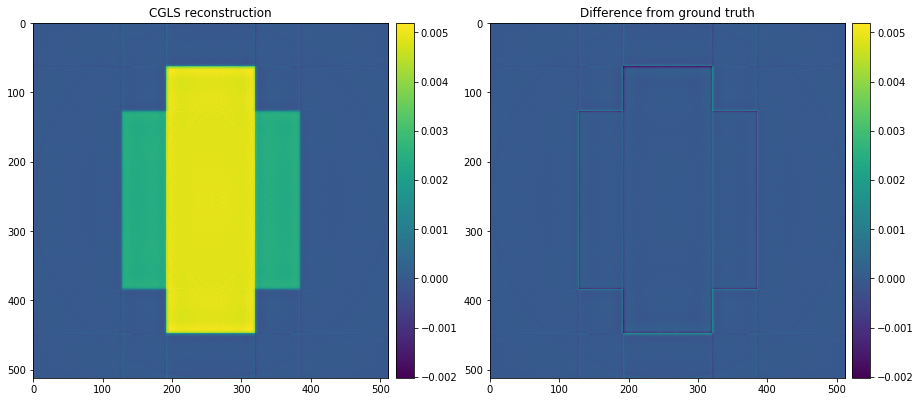

In [22]:
# get and visusualise the results
CGLS_res = cgls.get_output()

plotter2D([CGLS_res, CGLS_res - data],
          ["CGLS reconstruction", "Difference from ground truth"],
          fix_range = True)

Alternatively, tolerance can be used as a stopping criterion.

In [23]:
# setup CGLS
cgls = CGLS(x_init = x_init, 
            operator = operator, 
            data = ad,
            tolerance = 1e-4) # default 1e-6
cgls.max_iteration = 500
cgls.update_objective_interval = 10

CGLS setting up
CGLS configured


In [24]:
# run N interations
cgls.run(200, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          1.26805e+05
       10        500         1.572          1.71970e+04
       20        500         1.348          1.37794e+00
       22        500         1.347          7.82737e-02
Tolerance is reached: 0.0001


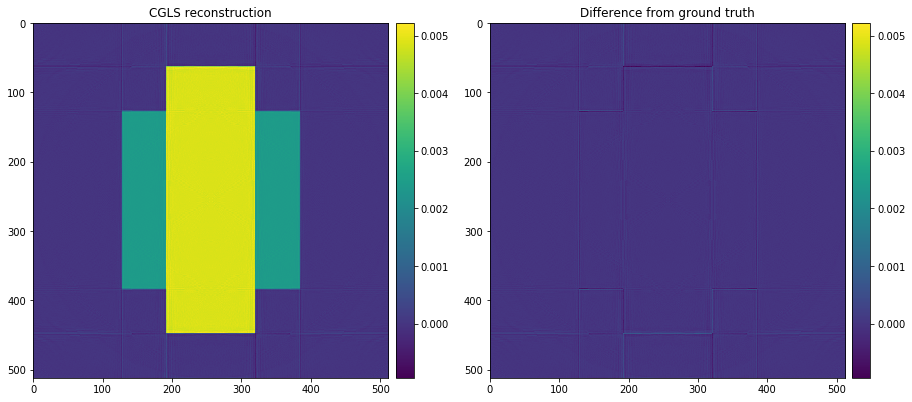

In [25]:
# get and visusualise the results
CGLS_res = cgls.get_output()

plotter2D([CGLS_res, CGLS_res - data],
          ["CGLS reconstruction", "Difference from ground truth"],
          fix_range = True)

In CGLS without explicit regularization, the number of iterations plays the role of a regularisation parameter. However, it is often unclear how many iterations is required to get 'good' reconstruction. Let us reconstruct the noisy dataset and visualise intermediate reconstruction results to control quality.

CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         20         0.000          1.32127e+05
        1         20         0.000          2.02681e+04
        2         20         1.329          3.61560e+03
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        3         20         1.356          2.72253e+03
        4         20         1.385          2.32646e+03
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        5         20         1.331          2.08602e+03
        6         20         1.353          1.84477e+03
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        7         20         1.341          1.69123e+03
        8         20         1.328          1.46541e+03
     Iter   Max 

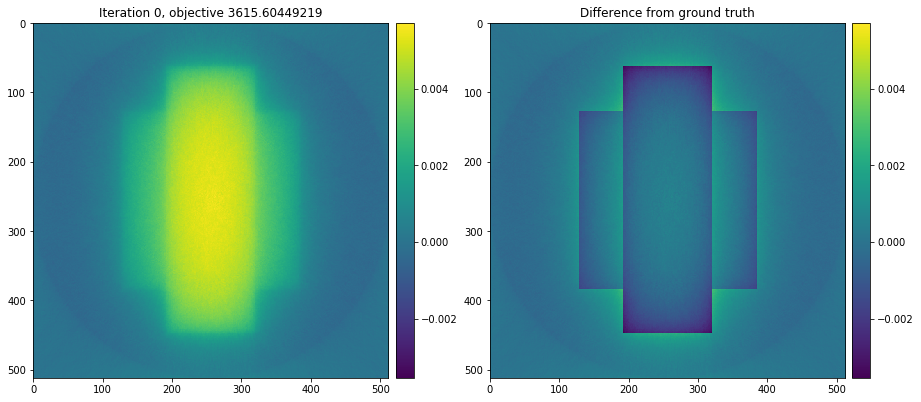

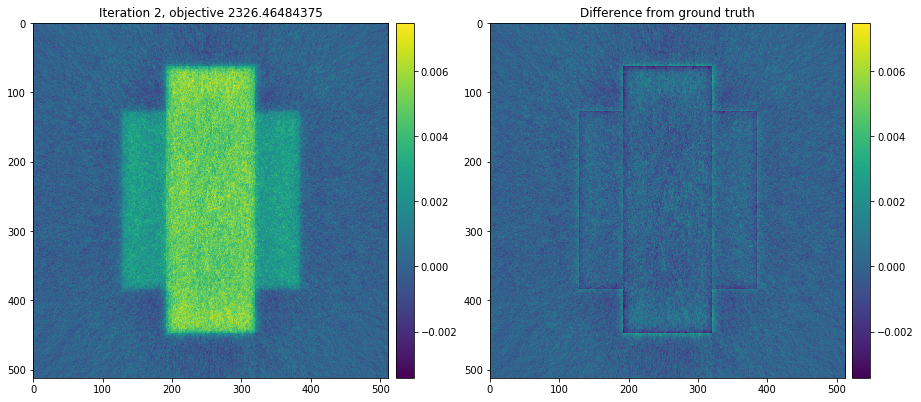

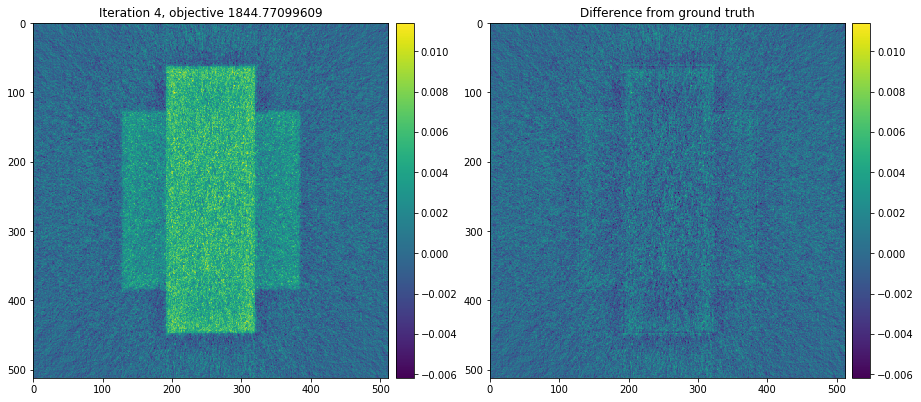

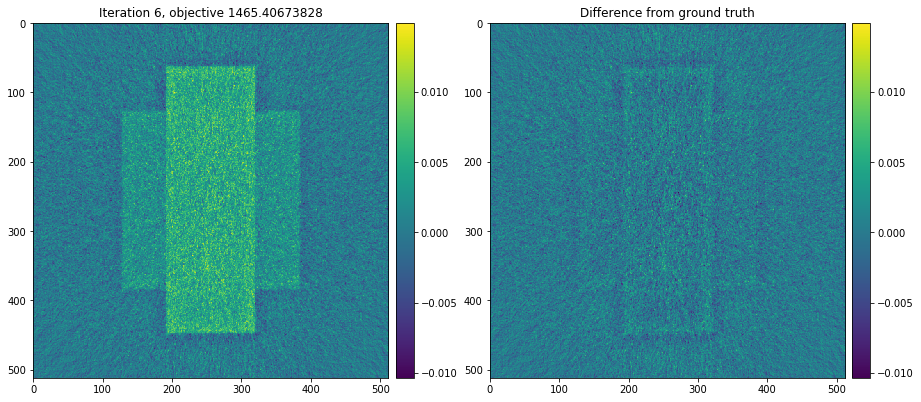

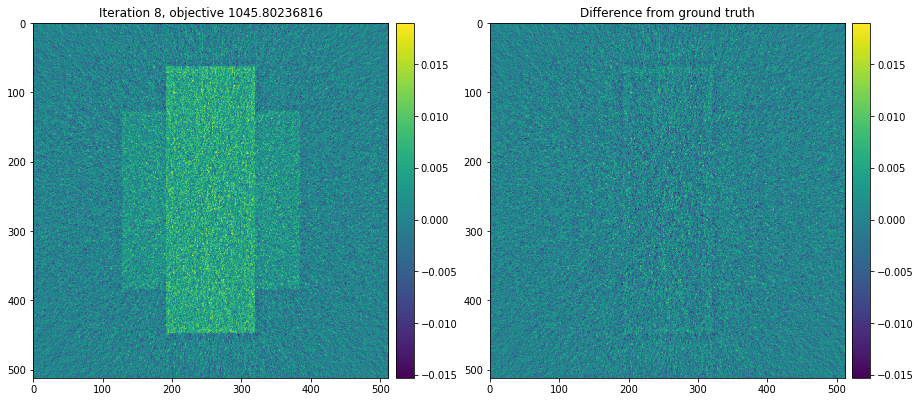

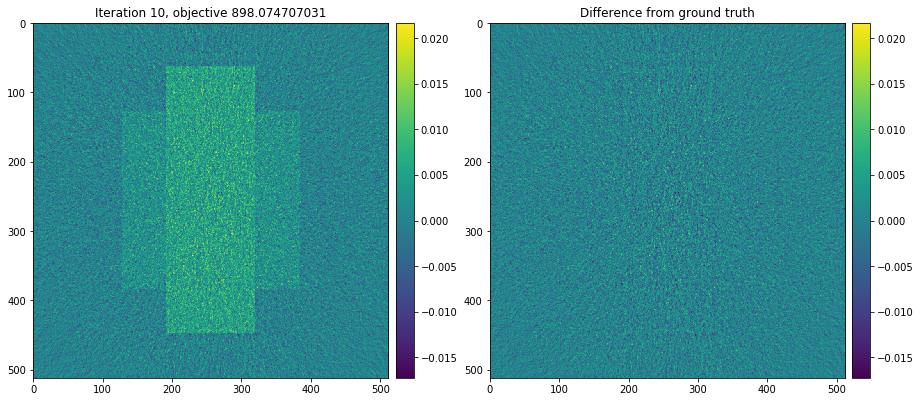

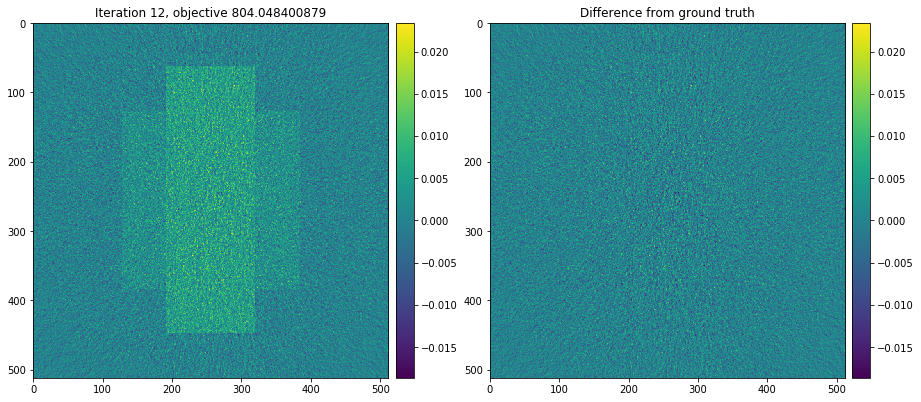

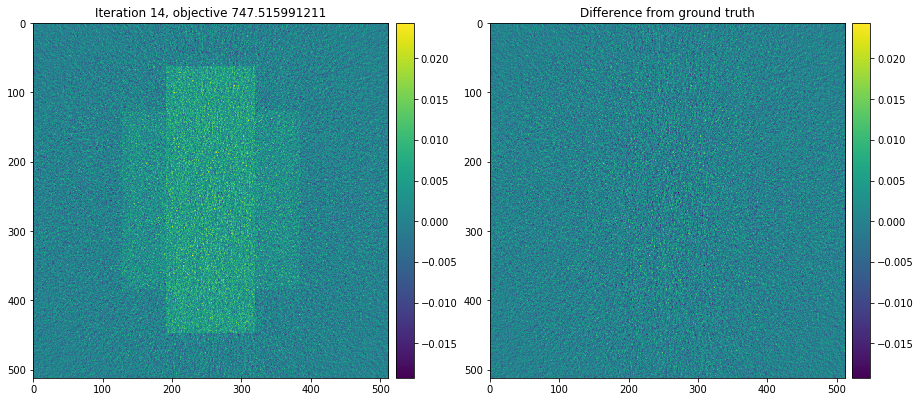

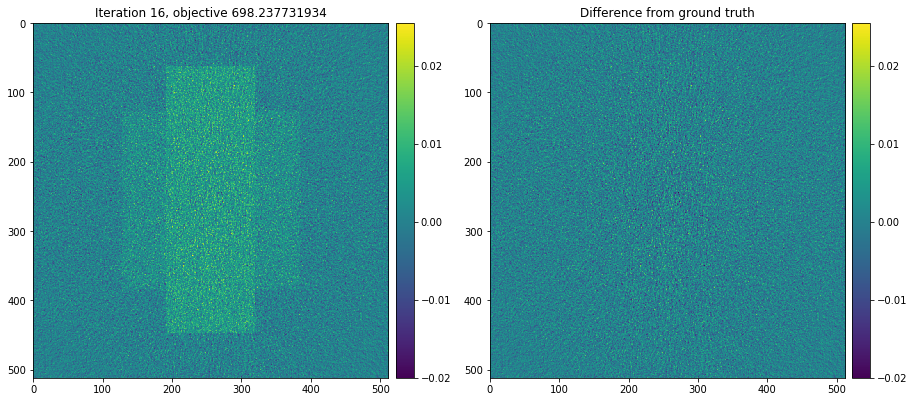

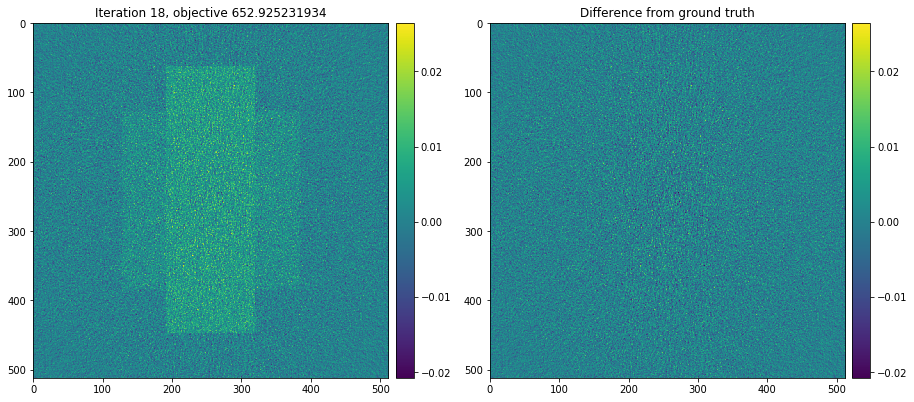

In [26]:
max_iter = 20
step = 2

# setup CGLS
cgls = CGLS(x_init = x_init, 
            operator = operator, 
            data = ad_noisy)
cgls.max_iteration = max_iter

for i in range(0, max_iter // step):
    cgls.run(step, verbose = True)
    
    # get and visusualise the results
    CGLS_res = cgls.get_output()

    plotter2D([CGLS_res, CGLS_res - data],
              ["Iteration {}, objective {}".format(i * step, cgls.loss[-1]), "Difference from ground truth"],
              fix_range = True)

You can see that after iteration 4, reconstruction gets more noisy even though objective value keeps decreasing. After iteration 8, you cannot see any significant changes in the reconstruction result.

**Exercise 2**: set-up CGLS reconstruction for low-projection datasets ([go to excercise 1](#exercise_1)). Try to find number of iterations for the noisy dataset which gives the most interpretable results.

### Summary

In this notebook you have learn how to:
- create `AcquisitionGeometry` and `ImageGeometry`
- manipulate `AcquisitionData` and `ImageData`
- implement basic CT reconstructions, including analytic FBP and iterative CGLS reconstruction algorithms
- evaluate intermediate and final reconstruction results